In [76]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import cv2
import random
import seaborn as sns
import glob as glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [77]:
def make_dataframe(path, phase):
    categories = ['train', 'valid', 'test']
    data_list = {}
    
    for category in categories:
        data_list[category] = {'img_path' : [], 'xml_path' : []}
        dir_path = os.path.join(path, category)
        img_list = glob.glob(f"{dir_path}\\*.jpg")
        xml_list = glob.glob(f"{dir_path}\\*.xml")
        
        data_list[category]['img_path'] = img_list
        data_list[category]['xml_path'] = xml_list
    
    return pd.DataFrame(data_list[phase])

In [78]:
os.getcwd()

'c:\\Users\\Harvey\\Desktop\\Codes\\Python\\practice'

In [79]:
base_dir = os.getcwd() + '\\data\\datasets\\detection_set'
phase_list = ['train', 'valid', 'test']
df_train = make_dataframe(base_dir, 'train')
df_valid = make_dataframe(base_dir, 'valid')
df_test = make_dataframe(base_dir, 'test')

In [80]:
df_train

,img_path,xml_path
0,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
1,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
2,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
3,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
4,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
...,...,...
5800,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
5801,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
5802,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...
5803,c:\Users\Harvey\Desktop\Codes\Python\practice\...,c:\Users\Harvey\Desktop\Codes\Python\practice\...


In [81]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.classes = {'Gun' : 0, 'Knife' : 1, 'Plier' : 2, 'Scissor' :3 , 'Wrench' : 4}
        self.point = []
        self.width = 0
        self.height = 0
        
        
    def __getitem__(self, index):
        
        img_path = self.dataframe['img_path'][index]
        image = (cv2.imread(img_path)/255).astype(np.float32)
        image = cv2.resize(image, (512, 512), cv2.INTER_LINEAR)
        xml_path = self.dataframe['xml_path'][index]
        
        boxes = []
        labels = []
        tree = et.parse(xml_path)
        root = tree.getroot()
        # get image size
        size = root.find('size')
        img_w = size.find('width').text
        img_h = size.find('height').text
        img_d = size.find('depth').text
        # print('img shape :', img_w, img_h, img_d)

        # get object info
        for obj in root.findall('object'):
            # get label
            label = obj.find('name').text
            labels.append(self.classes[label])
            # print('label :', label)
            # get boundary box
            x_min = int(obj.find('bndbox').find('xmin').text)
            x_max = int(obj.find('bndbox').find('xmax').text)
            y_min = int(obj.find('bndbox').find('ymin').text)
            y_max = int(obj.find('bndbox').find('ymax').text)
            # print('box point :', x_min, x_max, y_min, y_max)
            
            original_h, original_w = int(img_h), int(img_w)
            x_min = (x_min / original_w) * 512
            x_max = (x_max / original_w) * 512
            y_min = (y_min / original_h) * 512
            y_max = (y_max / original_h) * 512
            boxes.append([x_min, y_min, x_max, y_max])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((np.array(boxes).shape[0],), dtype=torch.int64)
            # get boundary line
        target = {}
        target['image_id'] = torch.as_tensor(index)
        target['boxes'] = boxes
        target['labels'] = torch.as_tensor(labels)
        target['area'] = torch.as_tensor(area)
        target['iscrowd'] = torch.as_tensor(iscrowd)
        image = torch.from_numpy(image).permute(2, 0, 1)
        return image, target
    
    def __len__(self):
        return len(self.dataframe)

In [82]:
train_set = CustomDataset(df_train)
valid_set = CustomDataset(df_valid)
test_set = CustomDataset(df_test)

In [83]:
# import matplotlib.patches as patches
# points = train_set[0][1]['boxes'].numpy()
# labels = train_set[0][1]['labels'].numpy()
# fig, ax = plt.subplots()
# label_list = {0 : 'Gun', 1 : 'Knife', 2 : 'Plier', 3 : 'Scissor', 4 : 'Wrench'}
# image = train_set[0][0].numpy()
# plt.imshow(image)
# for point, label in zip(points, labels):
#     print(label)
#     ax.add_patch(patches.Rectangle((point[0], point[2]), point[1]-point[0], point[3]-point[2], fill=False))
#     ax.text((point[0] + point[1]) / 2, point[2], label_list[label], color='red')

In [84]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=512, max_size=512)
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [85]:
model = create_model(num_classes=5)
model = model.to('cuda')

In [86]:
def Preview(data, model=None, device='cuda', iou_threshold=0.5, score_threshold=0):
    class_name = {
    1: 'Scissor',
    2: 'Pocket knife',
    3: 'Knife',
    4: 'Utility knife',
    5: 'Multipurpose knife'
}
    plt.figure(figsize=(12,12))
    plt.imshow(data[0].numpy())
    ax = plt.gca()
    for i,box in enumerate(data[1]['boxes']):
        x1,y1, x2, y2 = box
        ground_truth = patches.Rectangle(
                            (x1,y1),
                            x2-x1, y2-y1,
                            edgecolor='blue',
                            linewidth=3,
                            fill=False )
        ax.add_patch(ground_truth)
        plt.text(10, 10, f'[Ground Truth]:' + f"{class_name[data[1]['labels'][i].item()]}", color='blue', fontsize=12)

    if model is not None:
        model.eval()
        rtn = model( torch.unsqueeze( data[0], 0 ).to(device) ) # 차원 확장
        class_pred = rtn[0]['labels'].detach().cpu()
        bbox = rtn[0]['boxes'].detach().cpu()
        scores = rtn[0]['scores'].detach().cpu()
        get = torchvision.ops.nms(boxes=bbox, scores=scores, iou_threshold=iou_threshold)

        for i, pred in enumerate(class_pred):
            if i not in get: continue
            if scores[i]<score_threshold: continue

            x1,y1, x2, y2 = bbox[i]
            prediction =  patches.Rectangle(
                                (x1,y1), x2-x1,  y2-y1,
                                edgecolor='red', linewidth=3, fill=False )
            ax.add_patch( prediction )
            plt.text(10, 20+10*i, f'[Prediction]  : {class_name[pred.item()]} - {scores[i]:.4f}', color='red', fontsize=12)
    plt.show()

In [87]:
# Preview(train_set[0])

In [88]:
BATCH_SIZE = 8
NUM_WORKERS = 0

In [89]:
def collate_fn(batch):
    return tuple(zip(*batch)) # 다양한 크기의 shape를 다루기 위해 조정

In [90]:
train_loader = DataLoader(train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          collate_fn=collate_fn
                          )

val_loader = DataLoader(valid_set,
                        batch_size=4,
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        collate_fn=collate_fn)

In [92]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [94]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

1024


In [95]:
# torchvision 코드를 받아 사용 - 일부 수정된 코드를 받아서 사용합니다.
# !git clone https://github.com/Adrian123K/torch_ref

In [96]:
import sys
sys.path.append('C:/Users/Harvey/Desktop/Codes/Python/practice/torch_ref/torchvision_ref') # 경로 추가

In [97]:
import torch_ref.torchvision_ref.engine as engine


In [98]:
# Params: 가중치 업데이트
params = [p for p in model.parameters() if p.requires_grad]

# SGD Optimizer
# optimizer = torch.optim.SGD(params, lr=0.01, weight_decay=0.0005)
# optimizer = torch.optim.AdamW(params, lr=0.0006, weight_decay=0.001)
# optimizer = torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
# optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.RMSprop(params, lr=0.01, momentum=0, alpha=0.99, eps=1e-8, centered=False, weight_decay=0, momentum_decay=0)
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, dampening=0, weight_decay=0.001, nesterov=False)


# lr_scheduler로 현재 learning rate를 3에폭 마다 95%로 감소
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)

In [99]:
num_epochs = 10

for epoch in range(num_epochs):
    engine.train_one_epoch(model, optimizer, train_loader, 'cuda', epoch, print_freq=50)

    # lr_scheduler 실행
    lr_scheduler.step()

    engine.evaluate(model, val_loader, device='cuda')
    torch.save(model.state_dict(), f"./last_epoch_model.pth")

Epoch: [0]  [  0/726]  eta: 0:07:29  lr: 0.000024  loss: 2.0224 (2.0224)  loss_classifier: 1.8100 (1.8100)  loss_box_reg: 0.0929 (0.0929)  loss_objectness: 0.1099 (0.1099)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 0.6194  data: 0.0848  max mem: 1970
Epoch: [0]  [ 50/726]  eta: 0:07:00  lr: 0.000713  loss: 0.4542 (0.8435)  loss_classifier: 0.2116 (0.5834)  loss_box_reg: 0.1503 (0.1317)  loss_objectness: 0.0763 (0.1129)  loss_rpn_box_reg: 0.0121 (0.0154)  time: 0.6510  data: 0.0774  max mem: 1970
Epoch: [0]  [100/726]  eta: 0:06:28  lr: 0.001402  loss: 0.3990 (0.6433)  loss_classifier: 0.2092 (0.4004)  loss_box_reg: 0.1566 (0.1486)  loss_objectness: 0.0375 (0.0810)  loss_rpn_box_reg: 0.0091 (0.0133)  time: 0.6055  data: 0.0777  max mem: 1970
Epoch: [0]  [150/726]  eta: 0:05:54  lr: 0.002091  loss: 0.4756 (0.6023)  loss_classifier: 0.2365 (0.3507)  loss_box_reg: 0.2111 (0.1730)  loss_objectness: 0.0310 (0.0658)  loss_rpn_box_reg: 0.0099 (0.0128)  time: 0.5902  data: 0.0772  max mem: 1970


In [162]:
image = cv2.imread('C:/Users/Harvey/Desktop/Codes/Python/practice/data/datasets/detection_set100/test/P00418_jpg.rf.a1d88bf23ac18a806ba8a9e527eb4eee.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)
image = torch.unsqueeze(image, 0)
image = image.to('cuda')
model.eval()
with torch.no_grad():
    output = model(image)

In [163]:
output

[{'boxes': tensor([[ 71.8806, 316.3147, 272.5230, 525.2189],
          [ 80.4497, 469.2681, 316.1796, 542.5615],
          [ 93.7702, 499.6140, 304.6242, 553.7172],
          [105.6871, 520.6338, 296.2791, 547.2150],
          [ 24.8877, 308.0561, 280.2896, 418.7239],
          [ 76.1803, 405.2415, 258.0621, 499.4671],
          [ 40.6714, 270.4513,  75.8716, 586.9902],
          [ 94.6383, 495.3779, 306.0388, 527.7081],
          [ 45.4066, 276.0309, 280.3481, 381.7522],
          [ 68.0968, 517.7040, 303.5078, 597.9366],
          [ 39.8043, 244.5664,  78.3812, 418.4573],
          [ 33.1472, 283.8098, 115.1011, 593.5239],
          [ 44.6625, 271.7601,  85.5605, 473.3693]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9847, 0.6612, 0.5551, 0.2929, 0.2218, 0.1810, 0.1579, 0.1155, 0.0858,
          0.0770, 0.0730, 0.0690, 0.0531], device='cuda:0')}]

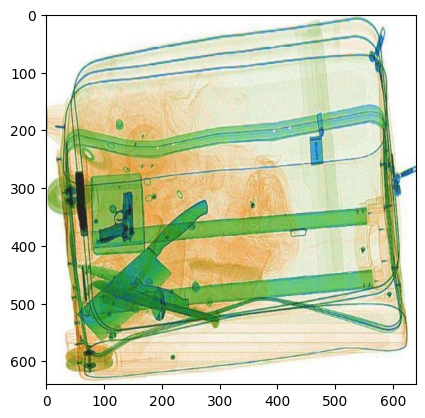

In [164]:
image_origin = cv2.imread('C:/Users/Harvey/Desktop/Codes/Python/practice/data/datasets/detection_set100/test/P00418_jpg.rf.a1d88bf23ac18a806ba8a9e527eb4eee.jpg', cv2.IMREAD_COLOR)
image_origin = cv2.cvtColor(image_origin, cv2.COLOR_BGR2RGB)
plt.imshow(image_origin)

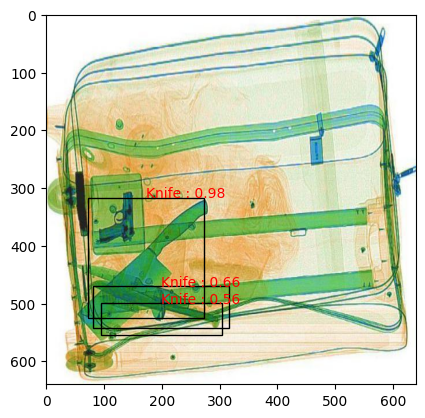

In [165]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2

points = output[0]['boxes'].cpu()
labels = output[0]['labels'].cpu()
scores = output[0]['scores'].cpu()
fig, ax = plt.subplots()
label_list = {0 : 'Gun', 1 : 'Knife', 2 : 'Plier', 3 : 'Scissor', 4 : 'Wrench'}
image = cv2.imread('C:/Users/Harvey/Desktop/Codes/Python/practice/data/datasets/detection_set100/test/P00418_jpg.rf.a1d88bf23ac18a806ba8a9e527eb4eee.jpg')
# image = cv2.resize(image, (512, 512), cv2.INTER_LINEAR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
for point, label, score in zip(points, labels, scores):
    if score.item() >= 0.5:
        ax.add_patch(patches.Rectangle((point[0], point[1]), point[2]-point[0], point[3]-point[1], fill=False))
        ax.text((point[0] + point[2]) / 2, point[1], f'{label_list[label.item()]} : {score.item():.2f}', color='red')